<center><h1>A Few Epidemiological Models</h1>
    Stephen Webb</center>
    
This is meant to provide a quick less on logistic growth, and why the basic model is useful for understanding epidemiological models.

In [1]:
# Standard imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns

# using inline, have to set the figure bigger
%matplotlib inline

# set figure parameters so they look pretty
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (9.5, 6),
         'axes.labelsize': 12,
         'axes.titlesize': 14,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12,
         'axes.spines.right' : False,
         'axes.spines.left' : False,
         'axes.spines.top' : False,
         'axes.spines.bottom' : False,
         'legend.fontsize': 14}
pylab.rcParams.update(params)

# I like to have more colors than what are available, so define tableau20 colors:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***
## Setting the Parameters of the Disease

We'll assume a few numbers for the disease, the number of people an average infected person will infect while they are ill, and the duration of the illness. This defines a rate of infection $R_0$ that will be a key feature of the models that follow.

In [2]:
# nominal, let's start with infecting 2.5 people every 17 days, like covid-19
days_ill_natural  = 17 # the natural lifetime of the virus
days_ill_medicine = 17 # the possibility of medical intervention
infected_ppl_per_person = 2.5 # This will be a really complicated function of the number 
                              # of people a typical person meets per day times the probability 
                              # each one gets infected, but we will pretend it's a number
        #
        # for some references on this number
        #    measles, 12-18 (!!!!!! vaccinate your kids)
        #    seasonal flu, 2
        #    spanish flu, 1.4-2.8
        #    H1N1 swine flu, 1.4-1.6

# R_0, how many people does each person infect per day
R_0 = infected_ppl_per_person/days_ill_natural

print('Number of people infected per day by an infected person \n R_0 = {} / day'.format(R_0))

Number of people infected per day by an infected person 
 R_0 = 0.14705882352941177 / day


In [3]:
# Set the total population of interest for logistic-type curves

total_pop = 55000000 # 5.5 million, aka the population of Colorado

***
## Exponential Growth -- Beyond the Worst Case Scenario

The most basic notion of a disease spreading is that an infected person will infect $r_0$ other people per day, on average. If there are $N_i$ infected people on day $i$, then on the next day there will be $N_{i+1} = N_i + R_0 N_i$ infected people. This will lead to _exponential growth_.

This is a worst case scenario, since as we'll see we quickly run out of people to infect.

In [4]:
# We'll eventually fit this to data
def exp_func(day, tau, A0):
    """Exponential function, for fitting purposes, returns

         (day - day0)/tau
        2
    
    Args
    day : list
        day, time
        
    day0 : int
        fitting parameter for the day of initial infection
        
    tau : float
        exponential growth rate"""
    
    return A0 * (2.**(day/tau))

def log_exp_func(day, tau, A0):
    """Logarithm of the above function"""
    
    return np.log(A0) + day*np.log(2.)/tau

In [5]:
# start with one patient, who infects someone else, who...
N = 1

# how long do we want to run this model
days_of_contagion = 200
current_day = 0

days = []
N_infect = []

while current_day < days_of_contagion:
    N_infect.append(N)
    days.append(current_day)

    # Here's that equation for exponential growth from up there
    N = N + R_0*N
    current_day += 1
    
days = np.array(days)
N_infect = np.array(N_infect)

Text(0.5, 1.0, 'Total infected, exponential model')

Text(0.5, 0, 'days')

Text(0, 0.5, 'infected')

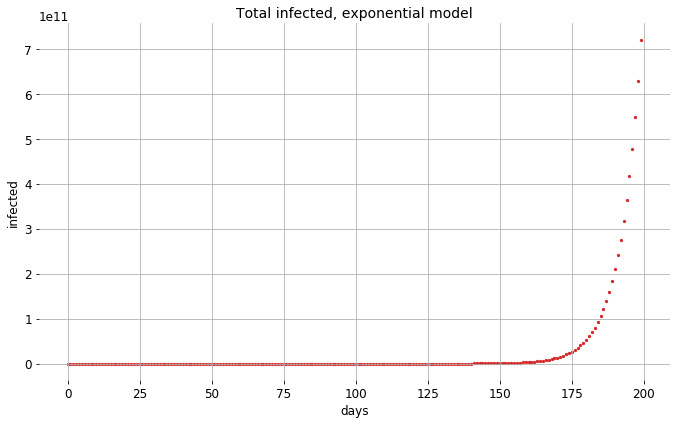

In [6]:
fig, ax = plt.subplots()

ax.scatter(days, N_infect, s=5, c='tab:red', label='total infected')
ax.grid()
ax.set_title('Total infected, exponential model')
ax.set_xlabel(r'days')
ax.set_ylabel(r'infected')

fig.tight_layout()

Let's fit our doubling exponential model to this, and see what happens.

Infections will double every 5 days


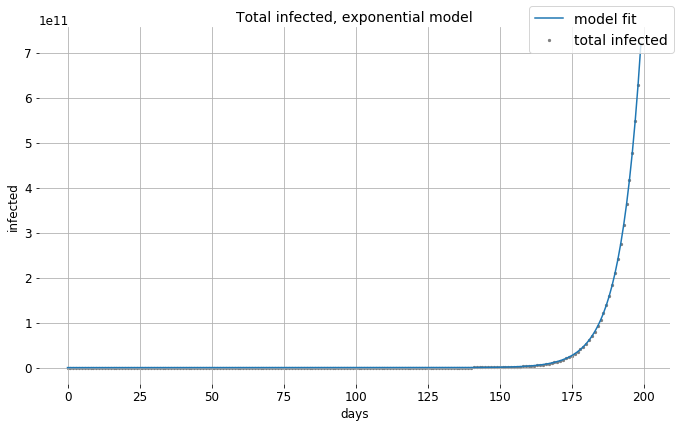

In [7]:
# It turns out it can be messy trying to fit data to an exponential, 
# that's how fast it's growing!,
# so it can help to fit the logarithmic data instead

log_N_infect = np.log(N_infect)

opt_params, cov_params = curve_fit(log_exp_func, days, log_N_infect, p0=[1., 1.])
print('Infections will double every {:0.0f} days'.format(opt_params[0]))

fig, ax = plt.subplots()

ax.scatter(days, N_infect, c='tab:gray', label='total infected', s=5)
ax.plot(days, exp_func(days, *opt_params), label='model fit')
ax.grid()
ax.set_title('Total infected, exponential model')
ax.set_xlabel(r'days')
ax.set_ylabel(r'infected')

fig.legend()
fig.tight_layout();

This is what exponential growth means. By the end of the year, we've gone from one patient to over 50,000,000 infected, with only a 5% chance of infecting any a new person each day. Now, this obviously can't go on forever, because even in the worst case scenario there's only so many people in the world you can infect.

This leads us to a more realistic model of an infection spreading, the logistic growth curve 

***
## Logistic Growth Curve -- A Finite Population

There is not an infinite population, so how do we deal with a population that has only so many people to infect?

This is where the logistic growth curve comes from. There are now two populations, $N^{(\textsf{infected})}$ and $N^{(\textsf{healthy})}$, and a total population $N^{(\textsf{pop.})} = N^{(\textsf{infected})} + N^{(\textsf{healthy})}$ which we'll assume is fixed (no births or deaths). 

Now, an infected person can only infect a healthy person, so the number of newly infected people comes from the rate of an infected person infecting an uninfected person, so that

$N^{(\textsf{infected})}_{i+1} = N^{(\textsf{infected})}_i + r_0 N^{(\textsf{infected})}_i N^{(\textsf{healthy})}_i$

Meanwhile, because the total population is fixed, we have that $N^{(\textsf{healthy})}_i = N^{(\textsf{pop.})} - N^{(\textsf{infected})}$, so our final equation gives the new total number of infections:

$N^{(\textsf{infected})}_{i+1} = N^{(\textsf{infected})}_i + r_0 N^{(\textsf{infected})}_i  \times (N^{(\textsf{pop.})} - N^{(\textsf{infected})})$

The equation is nonlinear, and we can look at how many new cases there are every day., $\Delta N^{(\textsf{infected})}_{i+1} = r_0 N^{(\textsf{infected})}_i  \times (N^{(\textsf{pop.})} - N^{(\textsf{infected})})$. At first, when very few people are infected, there are an increasing number of infections. Eventually, once half the population is infected, the number of new infections goes down, until eventually the whole population is infected. Let's look at the same exercise as last time, where here our $r_0 \times N^{(\textsf{pop.})} = R_0$ from before (*Exercise to the reader: why???*)

In [8]:
def logistic_func(days, days_0, tau, N_0):
    
    return N_0/(1. + np.exp(-(days-days_0)/tau))

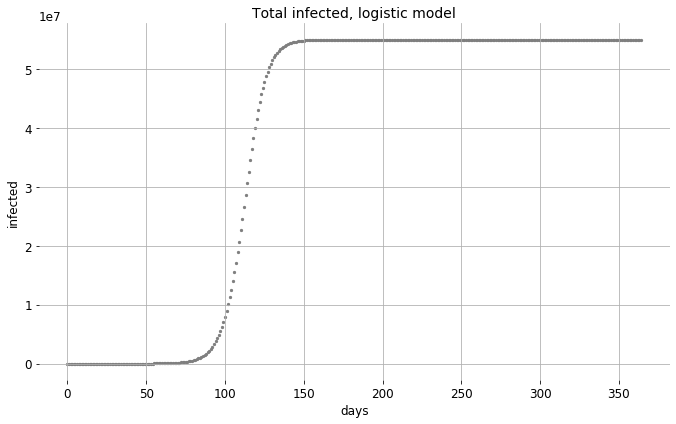

In [9]:
r_0 = R_0/total_pop
N = 10

# how long do we want to run this model
days_of_contagion = 365
current_day = 0

days = []
N_infect_logistic = []

while current_day < days_of_contagion:
    N_infect_logistic.append(N)
    days.append(current_day)

    # Here's that equation for exponential growth from up there
    N = N + r_0*N*(total_pop - N)
    current_day += 1
    
days = np.array(days)
N_infect_logistic = np.array(N_infect_logistic)

# Plot the results of this model
fig, ax = plt.subplots()

ax.scatter(days, N_infect_logistic, s=5, c='tab:gray', label='total infected')
ax.grid()
ax.set_title('Total infected, logistic model')
ax.set_xlabel(r'days')
ax.set_ylabel(r'infected')

fig.tight_layout();

Well that looks different!

Rather than continuing to grow indefinitely, it's rolling over and the total number of infected stops increasing (as it should, we can only infect so many). We can fit this to a _logistic function_

\begin{equation} 
\sigma = \frac{N_0}{1 + \exp \left [-(t - t_0)/\tau \right ]}
\end{equation}

parameter values: 
 t_0 = 112 days 
 tau = 7 days 
 N_0 = 55019972 


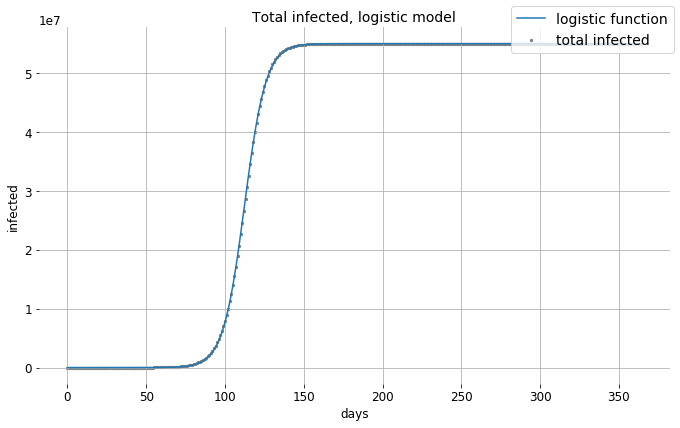

In [10]:
log_params, log_cov = curve_fit(logistic_func, days, N_infect_logistic, p0=[120, 14, total_pop])
print('parameter values: \n t_0 = {:0.0f} days \n tau = {:0.0f} days \n N_0 = {:0.0f} '.format(log_params[0], log_params[1], log_params[2]))

fig, ax = plt.subplots();

ax.scatter(days, N_infect_logistic, s=5, c='tab:gray', label='total infected')
ax.plot(days, logistic_func(days, log_params[0], log_params[1], log_params[2]), label='logistic function')
ax.grid()
ax.set_title('Total infected, logistic model')
ax.set_xlabel(r'days')
ax.set_ylabel(r'infected')

fig.legend()
fig.tight_layout();

As we can see, $N_0$ fits to roughly the population we gave it, and the time constant $\tau$ is close to, but not exactly, the 14 days from before. We also have this number, $t_0$, that we didn't have before. This is where the number of new cases starts to roll over.

So, on March 18, when a few people started noting that Italy's number of new infections seemed to have flattened out, it's this point in the curve they were talking about. At this point, new cases go down, and the end of the epidemic is in sight.

What happens if we lower the probability of infection by 10%? Let's repeat the logistic analysis, but for these two slightly different parameters.

In [11]:
r_0_lower = 0.9*R_0/total_pop
N = 1

# how long do we want to run this model
days_of_contagion = 365
current_day = 0

days = []
N_infect_lower = []

while current_day < days_of_contagion:
    N_infect_lower.append(N)
    days.append(current_day)

    # Here's that equation for exponential growth from up there
    N = N + r_0_lower*N*(total_pop - N)
    current_day += 1
    
days = np.array(days)
N_infect_lower = np.array(N_infect_lower)

parameter values: 
 t_0 = 143 days 
 tau = 8 days 
 N_0 = 55023384 


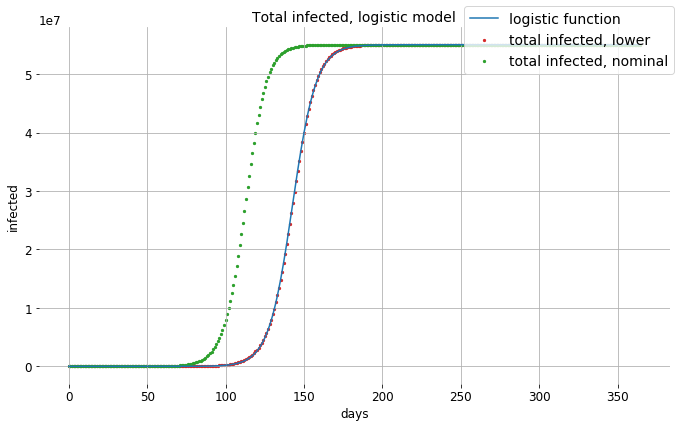

In [12]:
log_params, log_cov = curve_fit(logistic_func, days, N_infect_lower, p0=[120, 14, total_pop])
print('parameter values: \n t_0 = {:0.0f} days \n tau = {:0.0f} days \n N_0 = {:0.0f} '.format(log_params[0], log_params[1], log_params[2]))

fig, ax = plt.subplots();

ax.plot(days, logistic_func(days, log_params[0], log_params[1], log_params[2]), label='logistic function')
ax.scatter(days, N_infect_lower, s=5, c='tab:red', label='total infected, lower')
ax.scatter(days, N_infect_logistic, s=5, c='tab:green', label='total infected, nominal')
ax.grid()
ax.set_title('Total infected, logistic model')
ax.set_xlabel(r'days')
ax.set_ylabel(r'infected')

fig.legend()
fig.tight_layout();

What we see is that this relatively small change in the rate of infection means that we have substantially fewer cases after a year. This is why public health officials are pushing so hard for social distancing -- while the total number of cases may not go down, at least the hit on hospitals is lower, even with only a 10% lower chance of spreading the infection.

Both of these scenarios are bad, but the slower spread is less bad, making things spread out more and allowing the system to handle infected cases.

***
## SIR Model -- A Recovering Population

Let's look at something a bit more sophisticated. There are now three populations -- an infected population, a healthy population, and a _recovered_ population. The recovered population are people who got sick and are now either better or dead. Either way, they can't get sick anymore either!

The SIR model refers to the three buckets people go into: **S**usceptible, **I**nfected, or **R**ecovered. In this model, the population starts off completely susceptible. Then someone gets infected, they spread it to someone else who's infected, and on, like the exponential model. They can only spread it to people who are susceptible, and eventually they recover, and recovered people can't get infected again. Eventually, when enough people have recovered, the odds that an infected person can find a susceptible person and transmit the disease drops to the point that the disease cannot continue to spread -- each infected person infects less than one susceptible person on average. At this point, the disease cannot spread. Replace "recovered" with "immune", and this is how herd immunity works.

Let's say, for the sake of this model, that the disease is infectious for 5 days while people are ill, and after the 17th day everyone is recovered. Now, of course, there is some fraction of the population that will get better on the first day, the second, etc. until everyone is resolved, for better or worse, by 17 days. For the sake of argument, let's assume that probability is roughly linear i.e. nobody is better by day 1, 20% of the population is better by day 2, 40% by day 3, and on. Let's also assume those that recovered can't get reinfected, but only those infected can spread the disease.

So now the number of new infections is

\begin{equation}
N^{(\textsf{infected})}_{i+1} = N^{(\textsf{infected})}_{i} - \sum_{n=1}^{N_\textsf{recover}} p_n N^{(\textsf{infected})}_{i-n} + r_0 N^{(\textsf{infected})}_{i} N^{(\textsf{uninfected})}_{i}
\end{equation}

while the number of recovered is given by

\begin{equation}
N^{(\textsf{recovered})}_{i+1} = N^{(\textsf{recovered})}_{i} + \sum_{n=1}^{N_\textsf{recover}} p_n N^{(\textsf{infected})}_{i-n}
\end{equation}

and the previous total fixed population holds, $N^{(\textsf{infected})} + N^{(\textsf{recovered})} + N^{(\textsf{uninfected})} = N^{(\textsf{tot.})}$, which means that $ N^{(\textsf{uninfected})}_i = N^{(\textsf{tot.})} - N^{(\textsf{recovered})}_i - N^{(\textsf{infected})}_i$.

In [13]:
# We'll pretend that there's an even probability you'll recover in any number of days sick.
# This isn't perfect, but it's an easy first start.
N_last_n_days = np.zeros(days_ill_medicine)
#N_last_n_days_0 = np.zeros(days_ill_medicine)
p_rec = 1./days_ill_medicine


# use the same parameters as the logistic model to look at the total number of infected
N_inf = 7000
N_rec = 0

# how long do we want to run this model
days_of_contagion = 360
current_day = 0

days_sir = []
N_infected = []

N_recovered = []
N_uninfected = []

while current_day < days_of_contagion:
    N_infected.append(N_inf)
    N_recovered.append(N_rec)
    N_uninfected.append(total_pop - N_rec - N_inf)
    days_sir.append(current_day)

    # Here's that equation for exponential growth from up there
    new_cases = r_0 * N_inf * (total_pop - N_rec - N_inf)
    cured_cases = np.sum(N_last_n_days_0 * p_rec)
    N_inf = N_inf - cured_cases + new_cases
    N_rec = N_rec + cured_cases
    N_last_n_days[1:] = N_last_n_days[:-1]
    N_last_n_days[0] = new_cases
    current_day += 1
    
days_sir = np.array(days_sir)
N_recovered = np.array(N_recovered)
N_infected = np.array(N_infected)
N_uninfected = np.array(N_uninfected)

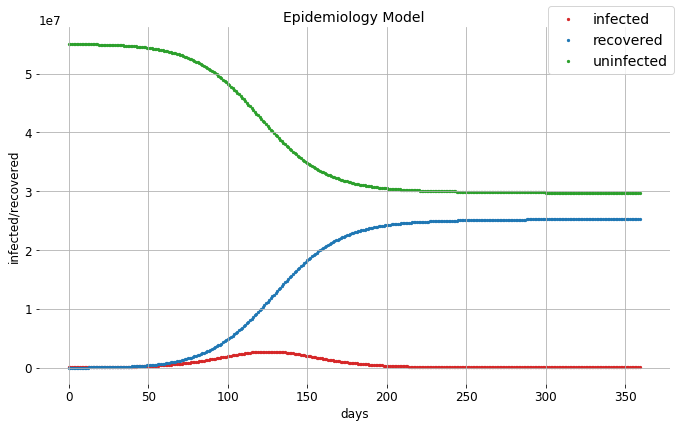

In [14]:
# Plot the number of people infected, uninfected, and recovered
fig, ax = plt.subplots()

ax.scatter(days_sir, N_infected, s=5, c='tab:red', label='infected')
ax.scatter(days_sir, N_recovered, s=5, c='tab:blue', label='recovered')
ax.scatter(days_sir, N_uninfected, s=5, c='tab:green', label='uninfected')

ax.grid()
ax.set_title(r'Epidemiology Model')
ax.set_xlabel(r'days')
ax.set_ylabel(r'infected/recovered')

fig.legend()
fig.tight_layout();

What we see is that we start off with an exponential growth model for the number of infected, but then at some point achieve herd immunity -- the disease can't propagate through the population effectively anymore, and dies out. For $R_0$ of 2.5, 17 days of illness, we top out at around 260,000 total people infected in Colorado, a state of 5.5 million, before we achieve herd immunity.

![title](./figs/colorado_covid19.png)

For contrast, if we practice social distancing and get the $R_0$ down from $2.5$ to $2.$, we get a curve that looks like this:

![title](./figs/colorado_covid19_short.png)

From this, we can infer that social distancing will slow the spread of the virus -- the so-called "flattening the curve" that epidemiologists and public health professionals have been hoping for -- which buys time for antivirals (which in this model reduces the days spent ill) or a vaccine (which effectively increases the "recovered" and relabels them "immune") which gets us to herd immunity faster.